Scratch pad to develop the dynamically-constrained super-resolution training pipeline. 

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import jax
import jax.numpy as jnp
import numpy as np

import keras
import jax_cfd.base as cfd
import jax_cfd.spectral as spectral

from typing import Callable

In [2]:
# setup problem and create grid
Lx = 2 * jnp.pi
Ly = 2 * jnp.pi
Nx = 128
Ny = 128
Re = 100.

grid = cfd.grids.Grid((Nx, Ny), domain=((0, Lx), (0, Ly)))

# estimate stable time step based on a "max velocity" using CFL condition
max_vel_est = 5.
dt_stable = cfd.equations.stable_time_step(max_vel_est, 0.5, 1./Re, grid) / 2.

First point to the data (small trajectories) and view to make sure appearance is realistic

In [3]:
data_loc = '/Users/jpage2/code/jax-cfd-data-gen/Re100test/'
file_front = 'vort_traj.'
n_zeros = 4

In [4]:
# add a new axis for "channels" and a new axis for "batch" (at front)
vort_example_traj = np.load(data_loc + file_front + str(70).zfill(4) + '.npy')[np.newaxis, :, :, :,np.newaxis]
vort_example_traj.shape

(1, 100, 128, 128, 1)

In [5]:
def average_pool_trajectory(omega_traj, pool_width, pool_height):
  batch_size, trajectory_length, Nx, Ny, Nchannels = omega_traj.shape
  assert Nx % pool_width == 0
  assert Ny % pool_height == 0

  omega_reshaped = omega_traj.reshape(
    (batch_size, trajectory_length, Nx // pool_width, pool_width, Ny // pool_height, pool_height, Nchannels)
  )
  omega_pooled_traj = omega_reshaped.mean(axis=(3, 5))
  return omega_pooled_traj

pooling_fn = jax.jit(average_pool_trajectory, static_argnums=(1, 2))


In [6]:
filter_size = 16
vort_traj_pooled = pooling_fn(vort_example_traj, filter_size, filter_size)

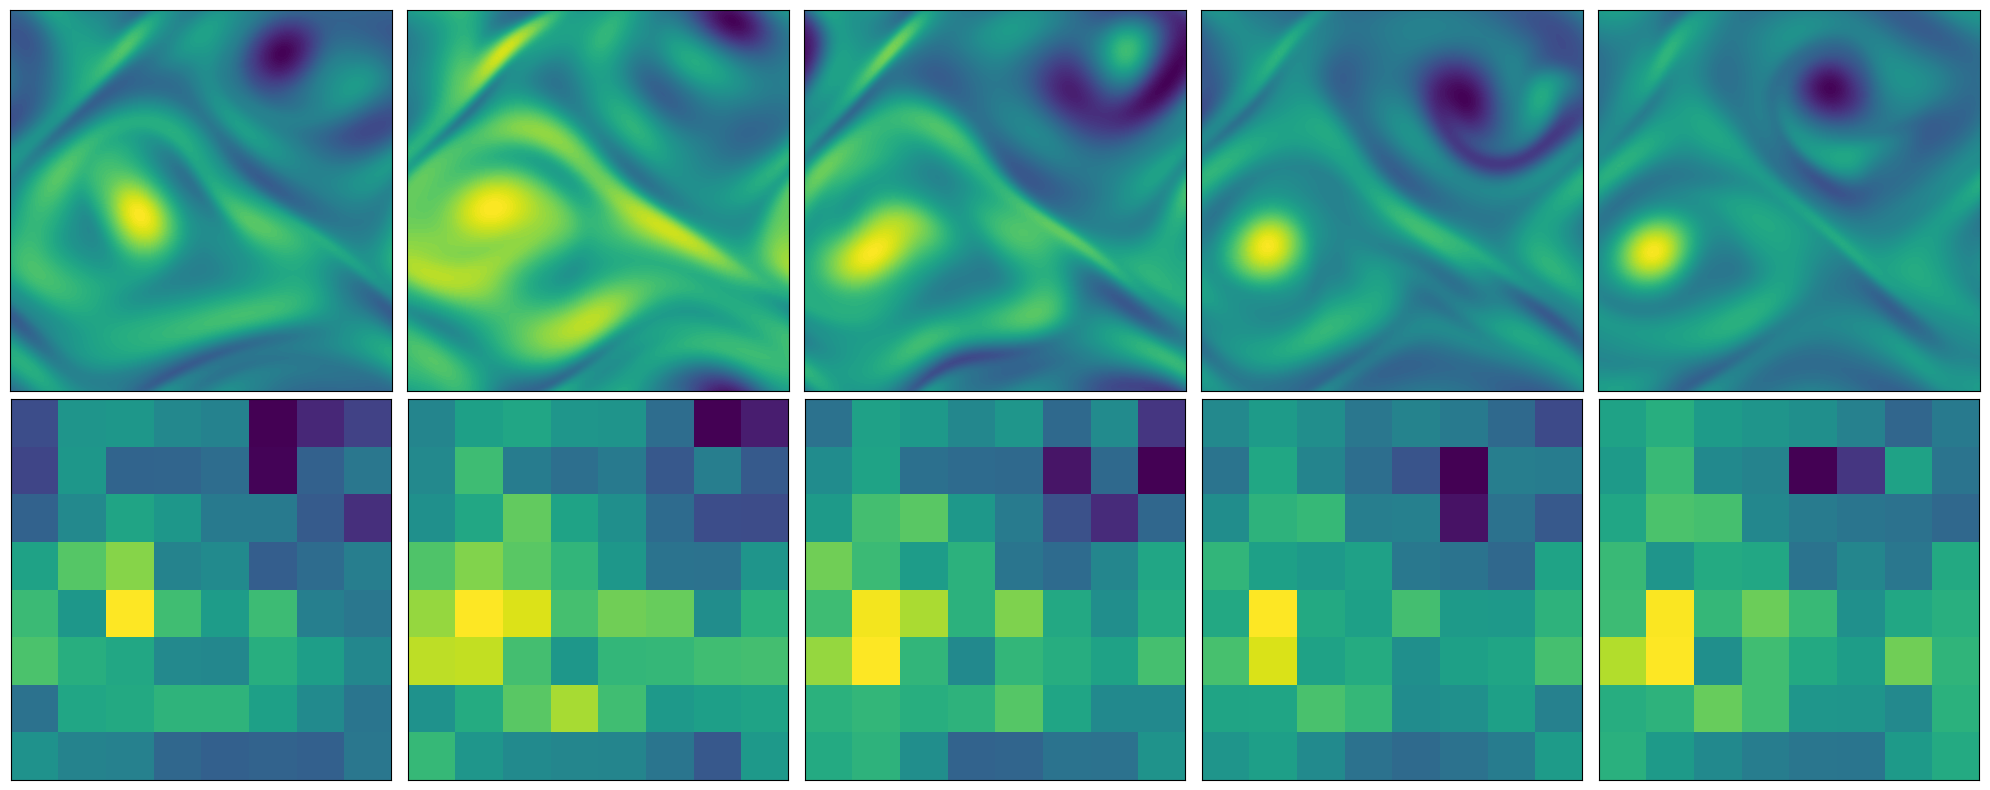

In [8]:
vort_traj_plot = jnp.squeeze(vort_example_traj)[:5]
vort_coarse_plot = jnp.squeeze(vort_traj_pooled)[:5]

import matplotlib.pyplot as plt

num_axes = len(vort_traj_plot)

fig = plt.figure(figsize=(4 * num_axes, 8))
ax_num = 1
for vort, vort_coarse in zip(vort_traj_plot, vort_coarse_plot):
  ax = fig.add_subplot(2, num_axes, ax_num)
  ax.contourf(vort.T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, num_axes, ax_num + num_axes)
  ax.imshow(vort_coarse.T, origin='lower')
  ax.set_xticks([])
  ax.set_yticks([])

  ax_num += 1
fig.tight_layout()

Let's build the ResNet-type model we will use to perform super resolution. The model should simply operate on batches of images, we need the loss (and data loading) to see the full trajectory though.

In [9]:
import models 
super_model = models.super_res_v0(Nx // filter_size, Ny // filter_size, 32, N_grow=4)

In [10]:
super_model.load_weights('weights/sr_best_MSE.weights.h5')

In [11]:
super_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8, 8, 1)   │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lambda (Lambda)     │ (None, 11, 11, 1) │       0 │ input_layer[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 8, 8, 32)  │     544 │ lambda[0][0]         │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │       0 │ conv2d[0][0]         │
│ (UpSampling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalization │ (None, 16, 16,    │     128 │ up_sampling2d[0][0]  │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 16, 16,    │       0 │ batch_normalization… │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lambda_1 (Lambda)   │ (None, 19, 19,    │       0 │ activation[0][0]     │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │  16,416 │ lambda_1[0][0]       │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │     128 │ conv2d_1[0][0]       │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lambda_2 (Lambda)   │ (None, 19, 19,    │       0 │ batch_normalization… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │  16,416 │ lambda_2[0][0]       │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add (Add)           │ (None, 16, 16,    │       0 │ conv2d_2[0][0],      │
│                     │ 32)               │         │ up_sampling2d[0][0]  │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ up_sampling2d_1     │ (None, 32, 32,    │       0 │ add[0][0]            │
│ (UpSampling2D)      │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │     128 │ up_sampling2d_1[0][… │
│ (BatchNormalizatio… │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation_1        │ (None, 32, 32,    │       0 │ batch_normalization… │
│ (Activation)        │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ lambda_3 (Lambda)   │ (None, 35, 35,    │       0 │ activation_1[0][0]   │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │  16,416 │ lambda_3[0][0]       │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼────────────────────

 Total params: 133,409 (521.13 KB)

 Trainable params: 132,897 (519.13 KB)

 Non-trainable params: 512 (2.00 KB)

Objective would be to initially pre-train this model on the pure reconstruction problem, prior to using the trajectory information in the loss.

Let's first verify we can run it on a small subset of the training data and train OK. 

Slightly awkward since we ultimately want to train on batches of trajectories, so for our initial tests involves some awkward reshaping

In [12]:
vort_snapshots = jnp.array([np.load(data_loc + file_front + str(n).zfill(4) + '.npy')[np.newaxis, 0, :, :,np.newaxis] for n in range(1000)])
vort_snapshots_coarse = average_pool_trajectory(vort_snapshots, filter_size, filter_size)

vort_snapshots = vort_snapshots[:, 0]
vort_snapshots_coarse = vort_snapshots_coarse[:, 0]

In [13]:
vort_snapshots_coarse.shape

(1000, 8, 8, 1)

In [ ]:
import matplotlib.pyplot as plt

num_axes = len(vort_traj_plot)

fig = plt.figure(figsize=(4 * num_axes, 12))
ax_num = 1
for vort, vort_coarse in zip(vort_snapshots_test[:10], vort_snapshots_coarse_test[:10]):
  ax = fig.add_subplot(3, num_axes, ax_num)
  ax.contourf(vort[:, :, 0].T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(3, num_axes, ax_num + num_axes)
  ax.imshow(vort_coarse[:, :, 0].T, origin='lower')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(3, num_axes, ax_num + 2 * num_axes)
  vort_pred = super_model.predict(vort_coarse.reshape(
    (1, Nx // filter_size, Ny // filter_size, 1))
    )
  
  rel_error = jnp.linalg.norm(vort_pred.flatten() - vort.flatten()) / jnp.linalg.norm(vort_pred.flatten())
  print(rel_error)

  # print(jnp.mean((vort_pred.reshape((Nx, Ny)) - vort[:, :, 0]) ** 2))

  ax.contourf(vort_pred[0, :, :, 0].T, 101)
  ax.set_xticks([])
  ax.set_yticks([])

  ax_num += 1
fig.tight_layout()